## First look at Huggingface datasets

Imports

In [48]:
from datasets import list_datasets
from datasets import load_dataset
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from transformers import AutoModel
import torch
import numpy as np
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [2]:
all_datasets = list_datasets(with_community_datasets=True, with_details=False)

/tmp/ipykernel_2848/3298537432.py:1: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  all_datasets = list_datasets(with_community_datasets = True, with_details = False )


In [3]:
all_datasets

['amirveyseh/acronym_identification',
 'ade_corpus_v2',
 'UCLNLP/adversarial_qa',
 'Yale-LILY/aeslc',
 'afrikaans_ner_corpus',
 'fancyzhx/ag_news',
 'allenai/ai2_arc',
 'google/air_dialogue',
 'komari6/ajgt_twitter_ar',
 'legacy-datasets/allegro_reviews',
 'tblard/allocine',
 'mutiyama/alt',
 'fancyzhx/amazon_polarity',
 'defunct-datasets/amazon_reviews_multi',
 'defunct-datasets/amazon_us_reviews',
 'sewon/ambig_qa',
 'nala-cub/americas_nli',
 'legacy-datasets/ami',
 'gavinxing/amttl',
 'facebook/anli',
 'app_reviews',
 'deepmind/aqua_rat',
 'google-research-datasets/aquamuse',
 'bigIR/ar_cov19',
 'hadyelsahar/ar_res_reviews',
 'iabufarha/ar_sarcasm',
 'arabic_billion_words',
 'QCRI/arabic_pos_dialect',
 'arabic_speech_corpus',
 'hsseinmz/arcd',
 'ramybaly/arsentd_lev',
 'allenai/art',
 'arxiv_dataset',
 'tuanphong/ascent_kb',
 'aslg_pc12',
 'AmazonScience/asnq',
 'facebook/asset',
 'nilc-nlp/assin',
 'nilc-nlp/assin2',
 'allenai/atomic',
 'autshumato',
 'facebook/babi_qa',
 'banking7

In [4]:
print(f"There are {len(all_datasets)} datasets currently available on the HF Hub.")
print(f"The first 10 are {all_datasets[:10]}")

There are 155168 datasets currently available on the HF Hub.
The first 10 are ['amirveyseh/acronym_identification', 'ade_corpus_v2', 'UCLNLP/adversarial_qa', 'Yale-LILY/aeslc', 'afrikaans_ner_corpus', 'fancyzhx/ag_news', 'allenai/ai2_arc', 'google/air_dialogue', 'komari6/ajgt_twitter_ar', 'legacy-datasets/allegro_reviews']


Load the emotion dataset

In [5]:
emotions = load_dataset("emotion")

/usr/local/lib/python3.8/dist-packages/datasets/load.py:1486: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [6]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [7]:
train_ds = emotions["train"]

In [8]:
train_ds
train_ds.column_names

['text', 'label']

In [9]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


In [10]:
emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [11]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)


df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


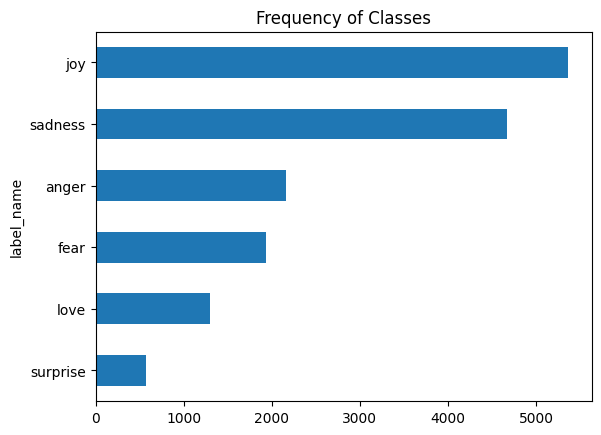

In [12]:
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

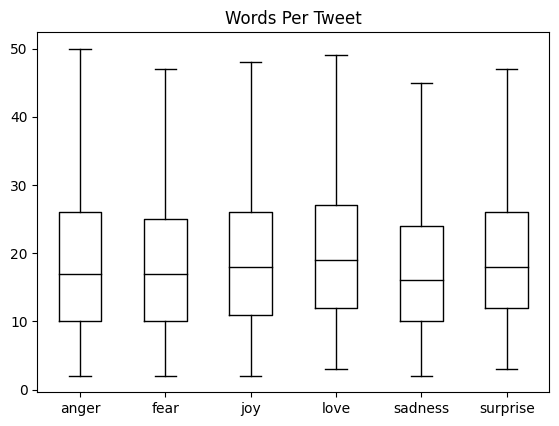

In [13]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot(
    "Words Per Tweet", by="label_name", grid=False, showfliers=False, color="black"
)
plt.suptitle("")
plt.xlabel("")
plt.show()

In [14]:
emotions.reset_format()

In [15]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [16]:
text = "Tokenizing text is a core task of NLP."
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [17]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


In [18]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


In [19]:
tokenizer.vocab_size

30522

In [20]:
tokenizer.model_max_length

512

In [21]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)


print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [22]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [23]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


In [24]:
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [25]:
print(device)

cuda


In [26]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [27]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


In [28]:
inputs = {key: value.to(device) for key, value in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [29]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

In [30]:
outputs.last_hidden_state[:, 0].size()

torch.Size([1, 768])

In [31]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {
        k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names
    }
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    return {"hidden_state": last_hidden_state[:, 0].cpu().numpy()}

In [32]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [33]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [34]:
emotions["train"][0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [35]:
emotions_hidden["train"][:1]

{'label': tensor([0]),
 'input_ids': tensor([[  101,  1045,  2134,  2102,  2514, 26608,   102,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0]]),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [37]:
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])

X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

In [38]:
# Scale features to the [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a df from 2d embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,3.941807,6.622201,0
1,-3.108758,5.630453,0
2,5.236826,3.177783,3
3,-2.349279,3.592469,2
4,-3.361433,3.640920,3


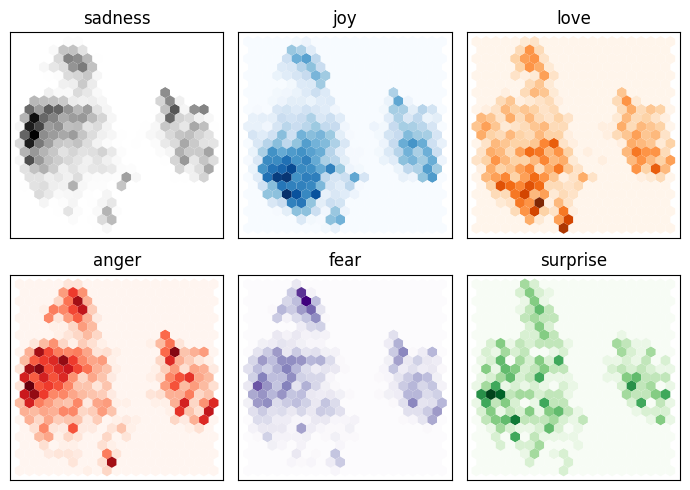

In [39]:
fig, axes = plt.subplots(2, 3, figsize=(7, 5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label=={i}")
    axes[i].hexbin(
        df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap, gridsize=20, linewidths=(0,)
    )
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

Training a simple classifier

In [42]:
# We increase max_iter to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.6335

In [46]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

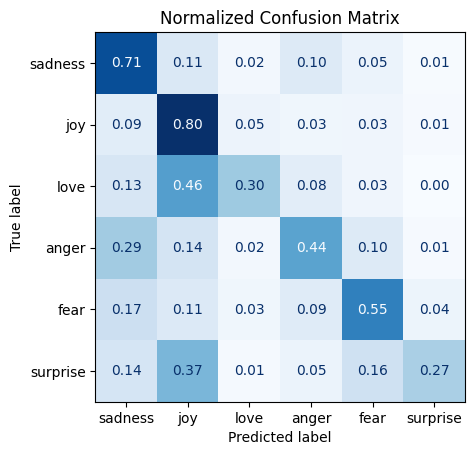

In [49]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots()
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized Confusion Matrix")
    plt.show()


y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

In [50]:
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (
    AutoModelForSequenceClassification.from_pretrained(
        model_ckpt, num_labels=num_labels
    )
).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [51]:
from sklearn.metrics import accuracy_score, f1_score


def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [52]:
from huggingface_hub import notebook_login

notebook_login()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [54]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_eval_batch_size=batch_size,
    per_device_train_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=True,
    log_level="error",
)

/transformers/src/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [57]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=emotions_encoded["train"],
    eval_dataset=emotions_encoded["validation"],
    tokenizer=tokenizer
)

trainer.train()

CODECARBON : No CPU tracking mode found. Falling back on CPU constant mode.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
CODECARBON : Failed to match CPU TDP constant. Falling back on a global constant.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.833800,0.318828,0.906000,0.904923
2,0.259900,0.221172,0.923000,0.922729


TrainOutput(global_step=500, training_loss=0.5468516387939453, metrics={'train_runtime': 283.2384, 'train_samples_per_second': 112.979, 'train_steps_per_second': 1.765, 'total_flos': 720342861696000.0, 'train_loss': 0.5468516387939453, 'epoch': 2.0})

In [58]:
preds_output = trainer.predict(emotions_encoded["validation"])

In [59]:
preds_output.metrics

{'test_loss': 0.22117196023464203,
 'test_accuracy': 0.923,
 'test_f1': 0.9227292162506584,
 'test_runtime': 5.4974,
 'test_samples_per_second': 363.811,
 'test_steps_per_second': 5.821}

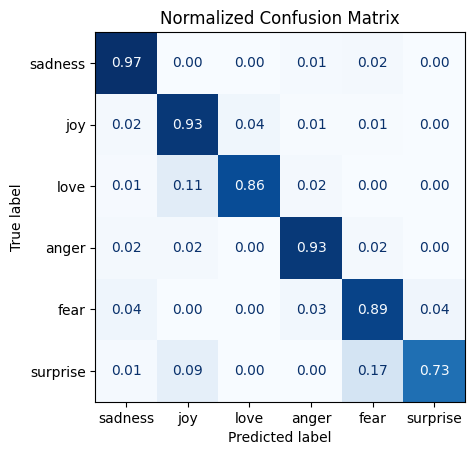

In [60]:
y_preds = np.argmax(preds_output.predictions, axis=1)
plot_confusion_matrix(y_preds,y_valid,labels)